In [1]:
import warnings
import paper_plotting


paper_plotting.set_figure_defaults()
warnings.filterwarnings("ignore")

In [2]:
# Rename the nwb file to because the name is too long for the database
# !mv sub-MS22_ses-Peter-MS22-180629-110319-concat_desc-processed_behavior+ecephys.nwb MS2220180629.nwb
import spyglass.data_import as sgi
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename


nwb_file_name = "MS2220180629.nwb"
nwb_file_copy_name = get_nwb_copy_filename(nwb_file_name)
interval_list_name = "pos 0 valid times"

sgi.insert_sessions(nwb_file_name)

[2024-02-08 14:11:12,700][INFO]: Connecting edeno@lmf-db.cin.ucsf.edu:3306
[2024-02-08 14:11:12,739][INFO]: Connected edeno@lmf-db.cin.ucsf.edu:3306


## Position

In [3]:
import spyglass.common as sgc

(
    sgc.RawPosition
    & {
        "nwb_file_name": nwb_file_copy_name,
        "interval_list_name": interval_list_name,
    }
).fetch1_dataframe()

,x,y,z
time,,,
6348.10810,-10.197975,-48.395540,10.530308
6348.11580,-10.422632,-48.345433,10.502238
6348.12415,-10.653343,-48.295335,10.474134
6348.13245,-10.889664,-48.245410,10.446101
6348.14080,-11.131063,-48.195860,10.418198
...,...,...,...
8003.52400,-5.543363,-57.925050,10.440041
8003.53230,-5.506644,-57.960373,10.448369
8003.54065,-5.471692,-57.993607,10.456156


In [4]:
import spyglass.position as sgp

trodes_params_name = "single_led_decoding"
trodes_params = {
    "max_separation": 10000.0,
    "max_speed": 300.0,
    "position_smoothing_duration": 0.125,
    "speed_smoothing_std_dev": 0.1,
    "orient_smoothing_std_dev": 0.001,
    "led1_is_front": 1,
    "is_upsampled": 1,
    "upsampling_sampling_rate": 250,
    "upsampling_interpolation_method": "linear",
}
sgp.v1.TrodesPosParams.insert1(
    {
        "trodes_pos_params_name": trodes_params_name,
        "params": trodes_params,
    },
    skip_duplicates=True,
)
sgp.v1.TrodesPosParams()

trodes_pos_params_name name for this set of parameters,params
default,=BLOB=
default_decoding,=BLOB=
default_led0,=BLOB=
max-sep_80,=BLOB=
single_led,=BLOB=
single_led_decoding,=BLOB=
single_led_upsampled,=BLOB=
upsample_1000_Hz,=BLOB=


In [5]:
trodes_s_key = {
    "nwb_file_name": nwb_file_copy_name,
    "interval_list_name": interval_list_name,
    "trodes_pos_params_name": trodes_params_name,
}
sgp.v1.TrodesPosSelection.insert1(
    trodes_s_key,
    skip_duplicates=True,
)

In [6]:
sgp.v1.TrodesPosV1.populate(trodes_s_key)

sgp.PositionOutput.TrodesPosV1 & {
    "nwb_file_name": nwb_file_copy_name,
    "interval_list_name": interval_list_name,
}

merge_id,nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,trodes_pos_params_name name for this set of parameters
ac9733fa-59b5-83de-e56d-efda4534975e,MS2220180629_.nwb,pos 0 valid times,single_led_decoding


[14:11:16][WARNING] Spyglass: Upsampled position data, frame indices are invalid. Setting add_frame_ind=False


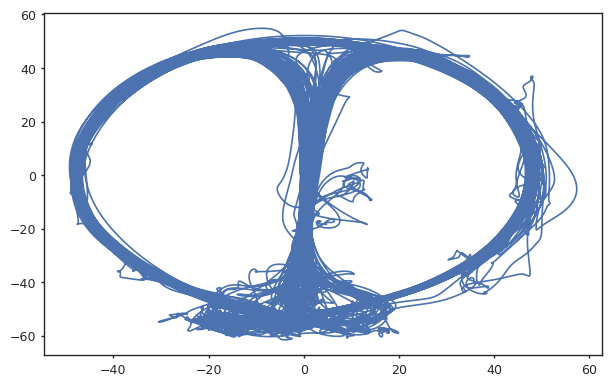

In [7]:
import matplotlib.pyplot as plt

pos_merge_key = (
    sgp.PositionOutput.TrodesPosV1
    & {
        "nwb_file_name": nwb_file_copy_name,
        "interval_list_name": interval_list_name,
    }
).fetch1("KEY")

position_info = (sgp.PositionOutput & pos_merge_key).fetch1_dataframe()
plt.plot(position_info["position_x"], position_info["position_y"])

In [8]:
position_info

,position_x,position_y,orientation,velocity_x,velocity_y,speed
time,,,,,,
6348.1081,-10.197975,-48.395540,0.0,-9.511337,1.588216,9.643027
6348.1121,-10.254139,-48.383013,0.0,-9.881969,1.637476,10.016718
6348.1161,-10.338890,-48.364224,0.0,-10.257622,1.686318,10.395310
6348.1201,-10.367477,-48.357961,0.0,-10.637884,1.734616,10.778380
6348.1241,-10.396063,-48.351699,0.0,-11.022324,1.782245,11.165484
...,...,...,...,...,...,...
8003.5413,-5.731288,-57.734329,0.0,3.100779,-3.813667,4.915169
8003.5453,-5.716341,-57.749568,0.0,3.030104,-3.704402,4.785825
8003.5493,-5.687011,-57.779309,0.0,2.957158,-3.594442,4.654546


In [9]:
import spyglass.decoding as sgd

position_merge_ids = (sgp.PositionOutput.TrodesPosV1 & trodes_s_key).fetch(
    "merge_id"
)
pos_group_name = nwb_file_copy_name.strip("_.nwb")

sgd.PositionGroup().create_group(
    nwb_file_name=nwb_file_copy_name,
    group_name=pos_group_name,
    keys=[{"pos_merge_id": merge_id} for merge_id in position_merge_ids],
    position_variables=["position_x", "position_y"],
)

sgd.PositionGroup & {
    "nwb_file_name": nwb_file_copy_name,
    "position_group_name": pos_group_name,
}

nwb_file_name name of the NWB file,position_group_name,position_variables list of position variables to decode
MS2220180629_.nwb,MS2220180629,=BLOB=


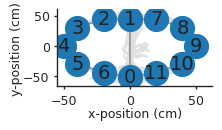

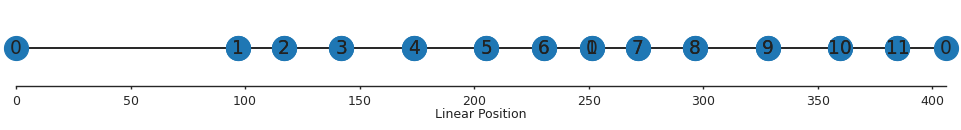

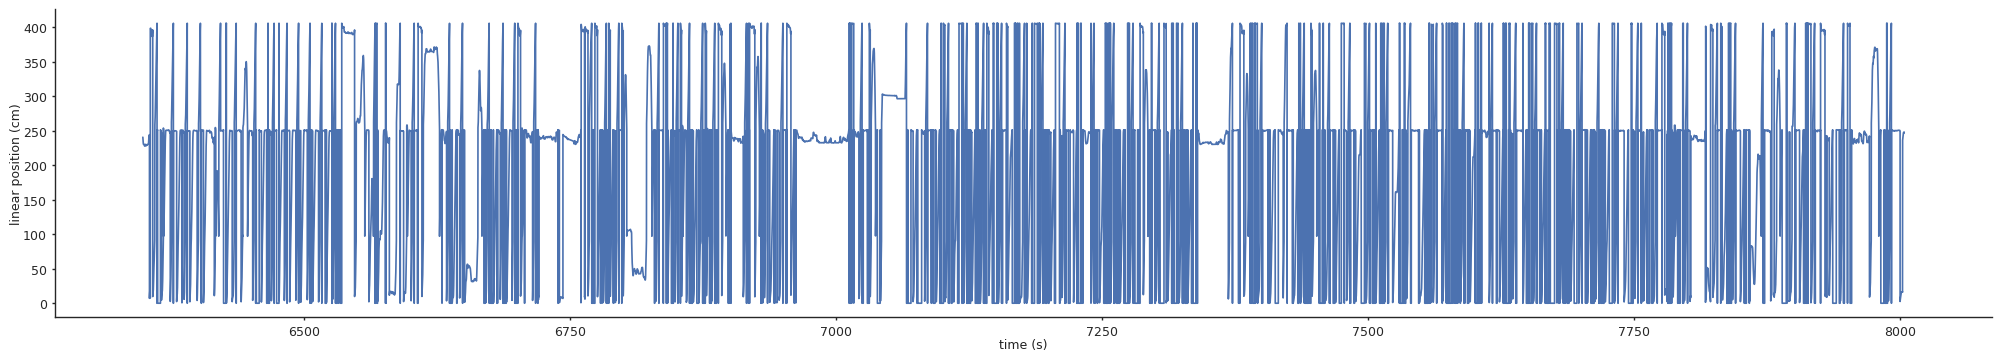

In [10]:
import track_linearization as tl

import numpy as np

node_positions = np.array(
    [
        (0, -52),  # center bottom
        (0, 45),  # center top
        (-20, 45),
        (-40, 30),  # left middle
        (-50, 0),
        (-40, -30),  # right middle
        (-20, -45),
        (20, 45),
        (40, 30),
        (50, 0),
        (40, -30),
        (20, -45),
    ]
)

edges = np.array(
    [
        (0, 1),
        (1, 2),
        (2, 3),
        (3, 4),
        (4, 5),
        (5, 6),
        (6, 0),
        (1, 7),
        (7, 8),
        (8, 9),
        (9, 10),
        (10, 11),
        (11, 0),
    ]
)

linear_edge_order = np.array(
    [
        (0, 1),
        (1, 2),
        (2, 3),
        (3, 4),
        (4, 5),
        (5, 6),
        (6, 0),
        (1, 7),
        (7, 8),
        (8, 9),
        (9, 10),
        (10, 11),
        (11, 0),
    ]
)
linear_edge_spacing = 0
track_graph = tl.make_track_graph(node_positions, edges)


fig, ax = plt.subplots(figsize=(2, 1))
ax.plot(
    position_info["position_x"],
    position_info["position_y"],
    color="lightgrey",
    alpha=0.7,
)
tl.plot_track_graph(track_graph, ax=ax, draw_edge_labels=False)
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("x-position (cm)")
ax.set_ylabel("y-position (cm)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

for node, (x, y) in enumerate(node_positions):
    ax.text(x, y, str(node), ha="center", va="center", fontsize=14)

fig, ax = plt.subplots(figsize=(12, 1))
tl.plot_graph_as_1D(
    track_graph,
    edge_spacing=linear_edge_spacing,
    edge_order=linear_edge_order,
    ax=ax,
)

linearized_position = tl.get_linearized_position(
    position=position_info[["position_x", "position_y"]].to_numpy(),
    track_graph=track_graph,
    edge_order=linear_edge_order,
)

fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(position_info.index, linearized_position["linear_position"])
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
ax.set_xlabel("time (s)")
ax.set_ylabel("linear position (cm)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

## Imported Spikesorting

In [11]:
import spyglass.spikesorting as sgs
from spyglass.spikesorting.spikesorting_merge import SpikeSortingOutput


SpikeSortingOutput()

sgs.v1.ImportedSpikeSorting.populate({"nwb_file_name": nwb_file_copy_name})

In [13]:
from spyglass.spikesorting.spikesorting_merge import SpikeSortingOutput

merge_id = (
    SpikeSortingOutput.merge_get_part({"nwb_file_name": nwb_file_copy_name})
).fetch1("merge_id")

SpikeSortingOutput() & {"merge_id": merge_id}

merge_id,source
a6a42f63-3f6a-4e89-0056-9fd8fc8d0791,ImportedSpikeSorting


In [14]:
(
    sgs.analysis.v1.group.UnitSelectionParams()
    & {"unit_filter_params_name": "exclude_noise"}
).fetch1("exclude_labels")

['noise', 'mua']

In [15]:
unit_selection_params_key = {
    "unit_filter_params_name": "MS2220180629",
    "include_labels": ["good", "good2"],
}

sgs.analysis.v1.group.UnitSelectionParams.insert1(
    unit_selection_params_key,
    skip_duplicates=True,
)

sgs.analysis.v1.group.UnitSelectionParams() & {
    "unit_filter_params_name": "MS2220180629",
}

unit_filter_params_name,include_labels,exclude_labels
MS2220180629,=BLOB=,=BLOB=


In [16]:
(
    sgs.analysis.v1.group.UnitSelectionParams()
    & {
        "unit_filter_params_name": "MS2220180629",
    }
).fetch1("include_labels", "exclude_labels")

(['good', 'good2'], None)

In [17]:
spikes_group_name = nwb_file_copy_name.strip("_.nwb")
sgs.analysis.v1.group.SortedSpikesGroup().create_group(
    group_name=spikes_group_name,
    nwb_file_name=nwb_file_copy_name,
    keys=[{"spikesorting_merge_id": merge_id}],
    unit_filter_params_name=unit_selection_params_key[
        "unit_filter_params_name"
    ],
)

sgs.analysis.v1.group.SortedSpikesGroup & {
    "sorted_spikes_group_name": spikes_group_name
}

nwb_file_name name of the NWB file,unit_filter_params_name,sorted_spikes_group_name
MS2220180629_.nwb,MS2220180629,MS2220180629


In [18]:
sgs.analysis.v1.group.SortedSpikesGroup.Units & {
    "sorted_spikes_group_name": spikes_group_name
}

nwb_file_name name of the NWB file,unit_filter_params_name,sorted_spikes_group_name,spikesorting_merge_id
MS2220180629_.nwb,MS2220180629,MS2220180629,a6a42f63-3f6a-4e89-0056-9fd8fc8d0791


## Decoding

In [19]:
from spyglass.decoding.v1.core import DecodingParameters
from non_local_detector import ContFragSortedSpikesClassifier
from non_local_detector.environment import Environment

decoding_param_name = nwb_file_copy_name.strip("_.nwb") + "_contfrag_sorted"
decoding_params = ContFragSortedSpikesClassifier(
    environments=Environment(
        place_bin_size=2.0,
        track_graph=track_graph,
        edge_order=linear_edge_order,
        edge_spacing=linear_edge_spacing,
    ),
)

DecodingParameters.insert1(
    {
        "decoding_param_name": decoding_param_name,
        "decoding_params": decoding_params,
    },
    skip_duplicates=True,
)

(DecodingParameters & {"decoding_param_name": decoding_param_name}).fetch1()

{'decoding_param_name': 'MS2220180629_contfrag_sorted',
 'decoding_params': {'discrete_initial_conditions': array([0.5, 0.5]),
  'continuous_initial_conditions_types': [UniformInitialConditions(),
   UniformInitialConditions()],
  'discrete_transition_concentration': 1.0,
  'discrete_transition_stickiness': array([0., 0.]),
  'discrete_transition_regularization': 1e-10,
  'discrete_transition_type': DiscreteStationaryDiagonal(diagonal_values=array([0.98, 0.98])),
  'continuous_transition_types': [[RandomWalk(environment_name='', movement_var=6.0, movement_mean=0.0, use_manifold_distance=False, direction=None),
    Uniform(environment_name='', environment2_name=None)],
   [Uniform(environment_name='', environment2_name=None),
    Uniform(environment_name='', environment2_name=None)]],
  'environments': [Environment(environment_name='', place_bin_size=2.0, track_graph=<networkx.classes.graph.Graph object at 0x7f8afe97f4f0>, edge_order=array([[ 0,  1],
          [ 1,  2],
          [ 2,  

In [20]:
sgc.IntervalList & {"nwb_file_name": nwb_file_copy_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start/end times for each interval,"pipeline type of interval list (e.g. 'position', 'spikesorting_recording_v1')"
MS2220180629_.nwb,decoding test interval,=BLOB=,
MS2220180629_.nwb,pos 0 valid times,=BLOB=,position


In [21]:
sgd.SortedSpikesDecodingSelection()

nwb_file_name name of the NWB file,unit_filter_params_name,sorted_spikes_group_name,position_group_name,decoding_param_name a name for this set of parameters,encoding_interval descriptive name of this interval list,decoding_interval descriptive name of this interval list,estimate_decoding_params whether to estimate the decoding parameters
mediumnwb20230802_.nwb,default_exclusion,test_group,test_group,contfrag_sorted,pos 0 valid times,test decoding interval,0
MS2220180629_.nwb,MS2220180629,MS2220180629,MS2220180629,MS2220180629_contfrag_sorted,pos 0 valid times,pos 0 valid times,1


In [22]:
decoding_selection_key = {
    "sorted_spikes_group_name": spikes_group_name,
    "position_group_name": pos_group_name,
    "decoding_param_name": decoding_param_name,
    "nwb_file_name": nwb_file_copy_name,
    "encoding_interval": "pos 0 valid times",
    "decoding_interval": "pos 0 valid times",
    "estimate_decoding_params": True,
    "unit_filter_params_name": "MS2220180629",
}

sgd.SortedSpikesDecodingSelection.insert1(
    decoding_selection_key,
    skip_duplicates=True,
)

sgd.SortedSpikesDecodingSelection & decoding_selection_key

nwb_file_name name of the NWB file,unit_filter_params_name,sorted_spikes_group_name,position_group_name,decoding_param_name a name for this set of parameters,encoding_interval descriptive name of this interval list,decoding_interval descriptive name of this interval list,estimate_decoding_params whether to estimate the decoding parameters
MS2220180629_.nwb,MS2220180629,MS2220180629,MS2220180629,MS2220180629_contfrag_sorted,pos 0 valid times,pos 0 valid times,1


In [23]:
import jax

device_id = 3
device = jax.devices()[device_id]
jax.config.update("jax_default_device", device)
device

2024-02-08 14:11:25.232015: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 0 and 9; status: INTERNAL: failed to enable peer access from 0x7f8768624c20 to 0x7f8748624d70: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2024-02-08 14:11:25.232848: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 1 and 9; status: INTERNAL: failed to enable peer access from 0x7f8764627410 to 0x7f8748624d70: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2024-02-08 14:11:25.233427: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 2 and 9; status: INTERNAL: failed to enable peer access from 0x7f876c6250e0 to 0x7f8748624d70: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2024-02-08 14:11:25.233923: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 3 and 9; status: INTERNAL: failed to enable peer access from 0x7f87

gpu(id=3)

In [24]:
sgd.SortedSpikesDecodingV1.populate(decoding_selection_key)

In [25]:
results = (sgd.SortedSpikesDecodingV1 & decoding_selection_key).fetch_results()
linear_position_info = sgd.SortedSpikesDecodingV1.fetch_linear_position_info(
    decoding_selection_key
)
posterior = results.acausal_posterior.unstack("state_bins").sum("state")
posterior

[14:11:26][WARNING] Spyglass: Upsampled position data, frame indices are invalid. Setting add_frame_ind=False
[14:11:30][WARNING] Spyglass: Upsampled position data, frame indices are invalid. Setting add_frame_ind=False


<xarray.DataArray 'acausal_posterior' (time: 413864, position: 207)>
array([[7.6162536e-07, 3.8177401e-05, 1.0925216e-03, ..., 1.5536533e-07,
        1.2714345e-07, 1.8378793e-07],
       [3.3639179e-05, 5.0473580e-04, 6.6031516e-03, ..., 1.8068031e-05,
        1.4933964e-05, 1.3801000e-05],
       [6.4583030e-05, 9.0968102e-04, 8.0279903e-03, ..., 6.0545563e-07,
        9.7034206e-07, 6.3451425e-06],
       ...,
       [6.8407990e-03, 5.5269315e-03, 5.1521468e-03, ..., 3.3173384e-03,
        4.4419351e-03, 6.8690232e-03],
       [8.1593236e-03, 6.4297765e-03, 5.7101650e-03, ..., 4.1761417e-03,
        5.3775441e-03, 7.6524918e-03],
       [8.7114684e-03, 6.6977567e-03, 5.7452782e-03, ..., 4.4528041e-03,
        5.7757148e-03, 8.2252091e-03]], dtype=float32)
Coordinates:
  * position  (position) float64 0.9898 2.969 4.949 6.929 ... 401.1 403.0 404.9
  * time      (time) float64 6.348e+03 6.348e+03 ... 8.004e+03 8.004e+03

In [26]:
multiunit_rate = sgd.v1.sorted_spikes.SortedSpikesGroup.get_firing_rate(
    decoding_selection_key, results.time.values, multiunit=True
).squeeze()

In [27]:
spike_times = sgd.SortedSpikesDecodingV1.fetch_spike_data(
    decoding_selection_key
)
len(spike_times)

172

In [28]:
from position_tools import get_angle

orientation = get_angle(
    position_info[["position_x", "position_y"]].shift(1).to_numpy(),
    position_info[["position_x", "position_y"]].to_numpy(),
)
orientation[np.isnan(orientation)] = 0.0
linear_position_info["orientation"] = orientation

In [29]:
classifier = (sgd.SortedSpikesDecodingV1 & decoding_selection_key).fetch_model()

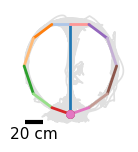

In [30]:
import paper_plotting
import matplotlib.cm as cm

reward_well_nodes = np.arange(1)
edge_colors = np.array(cm.get_cmap("tab20").colors)

paper_plotting.plot_2D_track_graph(
    track_graph=track_graph,
    position_info=linear_position_info,
    edge_order=linear_edge_order,
    reward_well_nodes=reward_well_nodes,
    edge_colors=edge_colors,
    position_names=("position_x", "position_y"),
)
paper_plotting.save_figure("figure5_buzsaki_track")

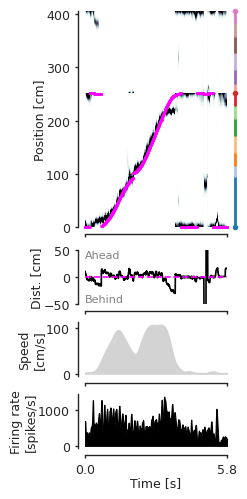

In [31]:
time_slice_ind = slice(229_500, 230_950)

paper_plotting.plot_decode(
    time_slice_ind=time_slice_ind,
    posterior=posterior,
    results=results,
    classifier=classifier,
    linear_position_info=linear_position_info,
    multiunit_rate=multiunit_rate,
    track_graph=track_graph,
    edge_spacing=linear_edge_spacing,
    edge_order=linear_edge_order,
    reward_well_nodes=reward_well_nodes,
    edge_colors=edge_colors,
)
paper_plotting.save_figure("figure5_buzsaki_decode")

In [32]:
paper_plotting.create_1D_interactive_figurl(
    linear_position_info,
    posterior,
    results,
    multiunit_rate,
    label="MS2220180629_sorted_decode",
    view_height=800,
    speed_name="speed",
)

'https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://ec5e8c82dd0d3eb000fc00f54a61a622e904766c&label=MS2220180629_sorted_decode&zone=franklab.default'

In [33]:
import non_local_detector.analysis as analysis

traj_data = analysis.get_trajectory_data(
    posterior=posterior,
    track_graph=track_graph,
    decoder=classifier,
    actual_projected_position=linear_position_info[
        ["projected_x_position", "projected_y_position"]
    ],
    track_segment_id=linear_position_info["track_segment_id"],
    actual_orientation=orientation,
)

ahead_behind_distance = analysis.get_ahead_behind_distance(
    track_graph, *traj_data
)

In [34]:
import pynwb

nwb_path = (sgc.Nwbfile & {"nwb_file_name": nwb_file_copy_name}).fetch1(
    "nwb_file_abs_path"
)

with pynwb.NWBHDF5IO(nwb_path, mode="r") as io:
    nwbfile = io.read()
    trials = nwbfile.intervals["trials"].to_dataframe()

In [35]:
trials.loc[
    trials["cooling state"] == "Pre-Cooling"
].start_time.min(), trials.loc[
    trials["cooling state"] == "Pre-Cooling"
].start_time.max()

(6357.4987, 6714.53255)

In [36]:
import pandas as pd


def interpolate_to_new_time(
    df, new_time, upsampling_interpolation_method="linear"
):
    old_time = df.index
    new_index = pd.Index(
        np.unique(np.concatenate((old_time, new_time))), name="time"
    )
    return (
        df.reindex(index=new_index)
        .interpolate(method=upsampling_interpolation_method)
        .reindex(index=new_time)
    )

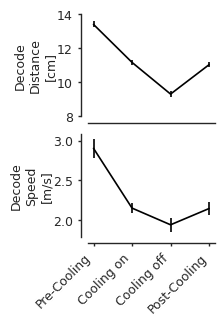

In [37]:
import scipy.stats
import seaborn as sns
from spectral_connectivity import multitaper_connectivity


ahead_behind_distance_stats = pd.DataFrame(
    {"ahead_behind_distance": ahead_behind_distance}, index=position_info.index
)
mobility_types = ["run"]
trial_types = ["Pre-Cooling", "Cooling on", "Cooling off", "Post-Cooling"]

fig, axes = plt.subplots(
    2,
    1,
    figsize=(
        0.9 * paper_plotting.TWO_COLUMN / 3,
        paper_plotting.PAGE_HEIGHT * 0.25 + paper_plotting.TWO_COLUMN / 3 * 0.3,
    ),
    constrained_layout=True,
)
sns.despine(offset=5, ax=axes[0])
for mobility_type in mobility_types:

    mean_by_trial_type = []
    sem_by_trial_type = []

    for trial_type in trial_types:
        trial_time_slice = slice(
            trials.loc[trials["cooling state"] == trial_type].start_time.min(),
            trials.loc[trials["cooling state"] == trial_type].stop_time.max(),
        )
        dist = np.abs(
            ahead_behind_distance_stats.loc[trial_time_slice]
            .to_numpy()
            .squeeze()
        )
        speed = (
            position_info.loc[trial_time_slice, "speed"].to_numpy().squeeze()
        )

        if mobility_type == "immobility":
            speed_filter = speed <= 10.0
        elif mobility_type == "run":
            speed_filter = speed > 10.0
        else:
            speed_filter = np.ones_like(dist, dtype=bool)

        mean_by_trial_type.append(dist[speed_filter].mean())
        sem_by_trial_type.append(scipy.stats.sem(dist[speed_filter]))

    axes[0].errorbar(
        trial_types,
        mean_by_trial_type,
        yerr=1.96 * np.asarray(sem_by_trial_type),
        label=mobility_type,
        color="black",
    )
    axes[0].set_xticks([])
    axes[0].set_ylim((8, 14))
    axes[0].set_yticks([8, 10, 12, 14])
    axes[0].set_ylabel("Decode\nDistance\n[cm]")

sns.despine(offset=5, ax=axes[1])
for mobility_type in mobility_types:
    mean_by_trial_type = []
    sem_by_trial_type = []
    for trial_type in trial_types:
        trial_time_slice = slice(
            trials.loc[trials["cooling state"] == trial_type].start_time.min(),
            trials.loc[trials["cooling state"] == trial_type].stop_time.max(),
        )
        decode_speed = (
            np.abs(
                np.gradient(
                    ahead_behind_distance_stats.loc[trial_time_slice]
                    .to_numpy()
                    .squeeze()
                )
            )
            / 0.004
        )
        speed = (
            position_info.loc[trial_time_slice, "speed"].to_numpy().squeeze()
        )

        if mobility_type == "immobility":
            speed_filter = speed <= 10.0
        elif mobility_type == "run":
            speed_filter = speed > 10.0
        else:
            speed_filter = np.ones_like(dist, dtype=bool)

        mean_by_trial_type.append((decode_speed[speed_filter] / (100.0)).mean())
        sem_by_trial_type.append(
            scipy.stats.sem(decode_speed[speed_filter] / 100.0)
        )

    axes[1].errorbar(
        trial_types,
        mean_by_trial_type,
        yerr=1.96 * np.asarray(sem_by_trial_type),
        label=mobility_type,
        color="black",
    )
    axes[1].set_xticklabels(
        trial_types, rotation=45, horizontalalignment="right"
    )
    axes[1].set_ylabel("Decode\nSpeed\n[m/s]")


paper_plotting.save_figure("figure5_buzsaki_distance_speed")

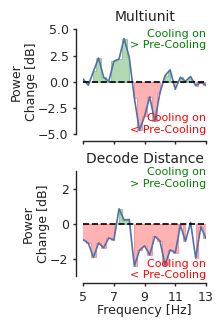

In [39]:
import seaborn as sns

fig, axes = plt.subplots(
    2,
    1,
    sharex=True,
    constrained_layout=True,
    figsize=(
        0.9 * paper_plotting.TWO_COLUMN / 3,
        paper_plotting.PAGE_HEIGHT * 0.25 + paper_plotting.TWO_COLUMN / 3 * 0.3,
    ),
)

time_window_duration = 3.000
sampling_frequency = 250
time_halfbandwidth_product = 1
start_time = position_info.index[0]

multiunit_power = multitaper_connectivity(
    multiunit_rate[:, None],
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=time_halfbandwidth_product,
    time_window_duration=time_window_duration,
    start_time=start_time,
    method="power",
).squeeze()
interp_pos_info = interpolate_to_new_time(
    position_info, multiunit_power.time, "linear"
)

mobility_type = "run"
log_power_by_trial_type = []
for trial_type in ["Pre-Cooling", "Cooling on"]:
    trial_time_slice = slice(
        trials.loc[trials["cooling state"] == trial_type].start_time.min(),
        trials.loc[trials["cooling state"] == trial_type].stop_time.max(),
    )
    speed = interp_pos_info.loc[trial_time_slice, "speed"].to_numpy().squeeze()

    if mobility_type == "immobility":
        speed_filter = speed <= 10.0
    elif mobility_type == "run":
        speed_filter = speed > 10.0
    else:
        speed_filter = np.ones_like(speed, dtype=bool)

    log_power_by_trial_type.append(
        10.0
        * np.log10(multiunit_power)
        .sel(time=trial_time_slice)
        .isel(time=speed_filter)
        .mean("time")
        .values
    )

multiunit_power_ratio = log_power_by_trial_type[1] - log_power_by_trial_type[0]

axes[0].plot(
    multiunit_power.frequency,
    multiunit_power_ratio,
)
axes[0].text(
    13,
    3,
    "Cooling on\n> Pre-Cooling",
    color="green",
    fontsize=8,
    ha="right",
    va="bottom",
)
axes[0].text(
    13,
    -3,
    "Cooling on\n< Pre-Cooling",
    color="red",
    fontsize=8,
    ha="right",
    va="top",
)
axes[0].fill_between(
    multiunit_power.frequency,
    multiunit_power_ratio,
    0.0,
    where=multiunit_power_ratio > 0,
    color="green",
    alpha=0.3,
    step="mid",
)
axes[0].fill_between(
    multiunit_power.frequency,
    multiunit_power_ratio,
    0.0,
    where=multiunit_power_ratio <= 0,
    color="red",
    alpha=0.3,
    step="mid",
)

axes[0].set_xlim((5, 13))
axes[0].set_ylim((-5, 5))
axes[0].axhline(0.0, color="black", linestyle="--")
axes[0].set_ylabel("Power\nChange [dB]")
axes[0].set_title("Multiunit", fontsize=10)

ahead_behind_power = multitaper_connectivity(
    ahead_behind_distance[:, None],
    sampling_frequency=sampling_frequency,
    time_halfbandwidth_product=time_halfbandwidth_product,
    time_window_duration=time_window_duration,
    start_time=start_time,
    method="power",
).squeeze()
interp_pos_info = interpolate_to_new_time(
    position_info, ahead_behind_power.time, "linear"
)

mobility_type = "run"
log_power_by_trial_type = []
for trial_type in ["Pre-Cooling", "Cooling on"]:
    trial_time_slice = slice(
        trials.loc[trials["cooling state"] == trial_type].start_time.min(),
        trials.loc[trials["cooling state"] == trial_type].stop_time.max(),
    )
    speed = interp_pos_info.loc[trial_time_slice, "speed"].to_numpy().squeeze()

    if mobility_type == "immobility":
        speed_filter = speed <= 10.0
    elif mobility_type == "run":
        speed_filter = speed > 10.0
    else:
        speed_filter = np.ones_like(speed, dtype=bool)

    log_power_by_trial_type.append(
        10.0
        * np.log10(ahead_behind_power)
        .sel(time=trial_time_slice)
        .isel(time=speed_filter)
        .mean("time")
        .values
    )

ahead_behind_power_ratio = (
    log_power_by_trial_type[1] - log_power_by_trial_type[0]
)

axes[1].plot(
    ahead_behind_power.frequency,
    ahead_behind_power_ratio,
)
axes[1].fill_between(
    ahead_behind_power.frequency,
    ahead_behind_power_ratio,
    0.0,
    where=ahead_behind_power_ratio > 0,
    color="green",
    alpha=0.3,
    step="mid",
)
axes[1].fill_between(
    ahead_behind_power.frequency,
    ahead_behind_power_ratio,
    0.0,
    where=ahead_behind_power_ratio <= 0,
    color="red",
    alpha=0.3,
    step="mid",
)

axes[1].text(
    13,
    2,
    "Cooling on\n> Pre-Cooling",
    color="green",
    fontsize=8,
    ha="right",
    va="bottom",
)
axes[1].text(
    13,
    -2,
    "Cooling on\n< Pre-Cooling",
    color="red",
    fontsize=8,
    ha="right",
    va="top",
)

axes[1].set_xlim((5, 13))
axes[1].set_ylim((-3, 3))
axes[1].axhline(0.0, color="black", linestyle="--")
axes[1].set_xlabel("Frequency [Hz]")
axes[1].set_ylabel("Power\nChange [dB]")
axes[1].set_title("Decode Distance", fontsize=10)
axes[1].set_xticks([5, 7, 9, 11, 13])

sns.despine(offset=5)

paper_plotting.save_figure("figure5_buzsaki_power")